In [25]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import matplotlib
from datetime import datetime

In [287]:
df=pd.read_csv("ActonMay4.csv")

In [288]:
df3=dataframe_org(df)

In [27]:
df2=df.sort_values(by=['measurement_end_utc'])

In [28]:
df2.index=pd.to_datetime(df2['measurement_end_utc'])

In [40]:
one_D=df2[df2["detector_id"]=="N24/012a1"].drop(["Unnamed: 0", "detector_id", "lon", "lat", "measurement_start_utc", "measurement_end_utc"], axis=1)

In [311]:
detectors=df3["detector_id"].drop_duplicates()
detector_sample=detectors.sample(n=10, random_state=1)
detectors=detectors.to_numpy()
detector_sample=detector_sample.to_numpy()


In [313]:
detector_sample

array(['N25/011c1', 'N25/011b2', 'N25/116e1', 'N27/265b1', 'N25/216e2',
       'N27/018c1', 'N25/011d2', 'N25/116a1', 'N27/012b1', 'N27/019b1'],
      dtype=object)

In [331]:
one_D

,n_vehicles_in_interval
measurement_end_utc,
2020-05-05 01:00:00,35
2020-05-05 02:00:00,31
2020-05-05 03:00:00,35
2020-05-05 04:00:00,26
2020-05-05 05:00:00,90
...,...
2020-06-04 20:00:00,277
2020-06-04 21:00:00,203
2020-06-04 22:00:00,202


In [102]:
match_timestamp = "00:00:00"

n=17
n=f'{n:02}'
print(q)
#one_D.index
one_D.loc[one_D.index.strftime("%H") == n].sum()

12


n_vehicles_in_interval    14506
dtype: int64

In [105]:
x=one_D.loc[one_D.index.strftime("%H") == n]['n_vehicles_in_interval'].sum()
print(x/one_D['n_vehicles_in_interval'].sum())

0.07126539555586124


In [319]:
def dataframe_org(df):
    df2=df.sort_values(by=['measurement_end_utc'])
    df2.index=pd.to_datetime(df2['measurement_end_utc'])
    df2=df2.drop(["Unnamed: 0", "measurement_start_utc", "measurement_end_utc"], axis=1)
    return df2
    
    

def MA(df, detector, past_days):
    one_D=df[df["detector_id"]==detector]
    return(one_D.tail(n=24*past_days)['n_vehicles_in_interval'].mean())

def MALD(df, detector, hour):
    one_D=df[df["detector_id"]==detector]
    hour=f'{hour:02}'
    beta=(one_D.loc[one_D.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(one_D['n_vehicles_in_interval'].sum())
    return beta

def MAGD(df, hour):
    hour=f'{hour:02}'
    beta=(df.loc[df.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(df['n_vehicles_in_interval'].sum())
    return beta

def forecast(df, detectors, days_in_past, days_in_future, display=False):
    framelist=[]
    for detector in detectors:
        meanV=MA(df, detector, days_in_past)
        pred=[]
        index=[]
        for i in range(1, 24*days_in_future +1):
            time=df.index[-1]+ np.timedelta64(i, 'h')
            beta=MALD(df, detector, time.hour)
            index.append(time)
            pred.append(beta*24*meanV)

        df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": pred})
        df2["detector_id"]=detector
        df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
        df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
        
        framelist.append(df2)
    DF=pd.concat(framelist)
    DF=DF.set_index('measurement_end_utc')
    
    if(display):
        for detector in detectors:
            DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()
    
    return DF
        
    

In [494]:
def holt_winters(df, detectors, days_in_past, days_in_future, alpha=0.1, beta=0.1, gamma=0.1, display=False):
    framelist=[]
    for detector in detectors:
        S=1; T=1; I=np.ones(24);
        past=df[df["detector_id"]==detector].tail(n=24*days_in_past)
        for i in range(0, len(past)):
            h=i%24
            c = past["n_vehicles_in_interval"][i]
            Snew = (alpha*(c/I[h])) + (1-alpha)*(S + T)
            T = beta*(Snew - S) + (1-beta)*T
            I[h] = gamma*(c/Snew) + (1-gamma)*I[h]
            S=Snew

        baseline=[]
        index = []
        for j in range(0, days_in_future*24):
            time=df.index[-1]+ np.timedelta64(j, 'h')
            h=j%24
            b=(S + T)*I[h]
            baseline.append(b)
            index.append(time)

            Snew = (alpha*(b/I[h])) + (1-alpha)*(S + T)
            T = beta*(Snew - S) + (1-beta)*T
            I[h] = gamma*(b/Snew) + (1-gamma)*I[h]
            S=Snew

        df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": baseline})
        df2["detector_id"]=detector
        df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
        df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
        framelist.append(df2)
    DF=pd.concat(framelist)
    DF=DF.set_index('measurement_end_utc')
    
    if(display):
        for detector in detectors:
            DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()

    return DF
        
        
        
    
    

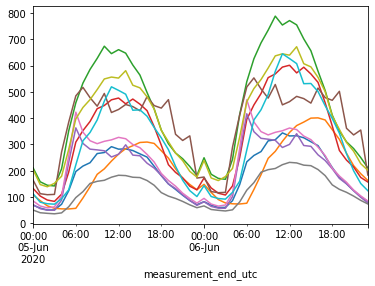

In [502]:
x=holt_winters(df3, detector_sample, 12, 2, display=True)


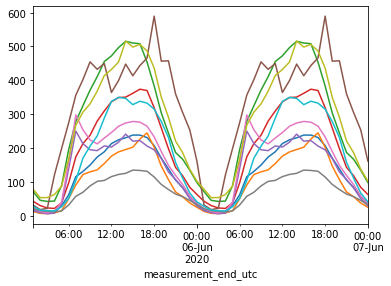

In [497]:
y=forecast(df3, detector_sample, 30, 2, display=True)

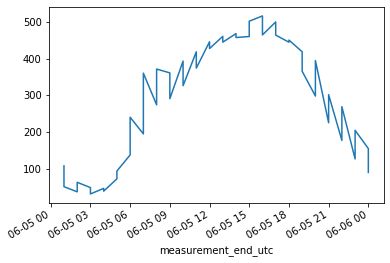

In [272]:
df5[df5["detector_id"]=="N27/299a1"]["n_vehicles_in_interval"].plot()

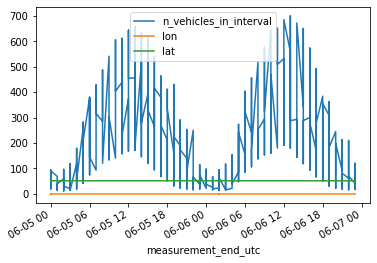

In [492]:
x.plot()

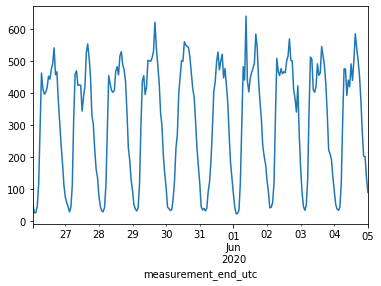

In [413]:
df3[df3["detector_id"]=="N24/012a1"].tail(n=24*10)["n_vehicles_in_interval"].plot()

In [321]:
print(MAGD(df3, 17), MALD(df3, "N24/012a1", 17))

0.06863983542005232 0.07126539555586124


In [260]:
df[df["detector_id"]=="N24/012a1"]["lon"][0]

-0.28800795553729697

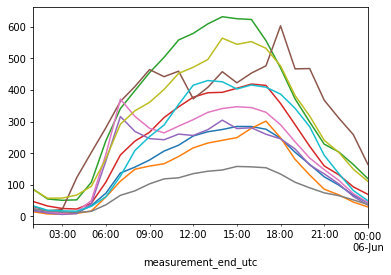

In [322]:
df5=forecast(df3, detector_sample, 1, 1, display=True)

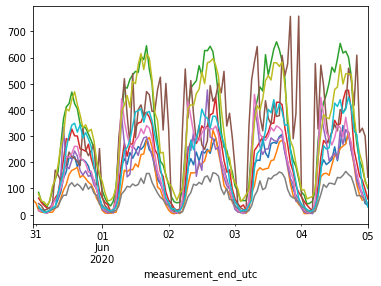

In [503]:
for detector in detector_sample:
            df3[df3["detector_id"]==detector].tail(24*5)["n_vehicles_in_interval"].plot()


In [215]:
df2=one_D.tail(n=24)
for i in range(0, len(df2)-1):
    print(df2["n_vehicles_in_interval"][i], df2["n_vehicles_in_interval"][i+1])

53 38
38 34
34 43
43 117
117 312
312 476
476 476
476 393
393 441
441 420
420 492
492 440
440 500
500 586
586 542
542 504
504 455
455 380
380 277
277 203
203 202
202 136
136 90


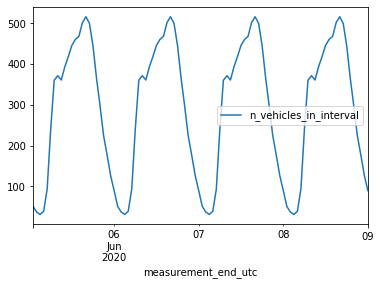

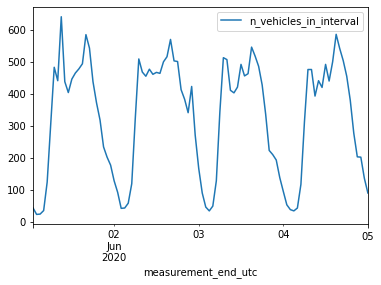

In [203]:
forecast(one_D, 20, 4).plot()
one_D.tail(n=24*4).plot()

In [130]:
def MA(df, past_days):
    return(df.tail(n=24*past_days)['n_vehicles_in_interval'].mean())
    
    

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2.index, df2['lon'], df2['lat'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')

TypeError: invalid type promotion

ValueError: view limit minimum -0.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units